In [7]:
%cd NLP_RL_Docker_Version/

[Errno 2] No such file or directory: 'NLP_RL_Docker_Version/'
/NLP_RL_Docker_Version


### CAREFUL

In [ ]:
# !rm -rf results/
!mkdir results

In [8]:
!python3 -W ignore ppo.py --model 0 --ease -1

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibilit

In [4]:
import sys 
sys.path.append('/NLP_RL_Docker_Version/gym-examples')
import gym 
import model as M
import model_nlp as MNLP
import utils as U
import torch
import copy
import gym_examples
suffix = [['easy','medium','hard','naive'],['fnlp_easy','fnlp_medium','fnlp_hard','fnlp_naive']]

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import json 
import matplotlib.pyplot as plt 

def plot_ppo(name):
    arr=[]
    with open(f'results/test_reward_list_{name}.json', 'r') as file:
        arr=json.load(file)
        x,y=[arr[i][0] for i in range(len(arr))], [arr[i][1] for i in range(len(arr))]
        plt.plot(x,y)
        plt.xlabel(f'Frame Number')
        plt.ylabel(f'Cumulative Reward')
        plt.show()

In [6]:
def run_best_env(number,name):
    str_arr = name.split('_')
    opt = 0
    if 'fnlp' in str_arr:
        opt = 1
    def policy(S):
        nonlocal opt 
        if opt == 0:
            dist, value = model(S['visual'])
        elif opt == 1:
            dist, value = model(S['visual'],S['text'])
        action = dist.sample()
        return action.cpu().numpy().item()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if opt == 0:
        model = M.NNModel().to(device)
    elif opt == 1:
        model = MNLP.NNModelNLP().to(device)
    model.load_state_dict(torch.load(f'results/model_{name}.ml'))
    dbg=True 
    episodes=1
    env = gym.make('gym_examples/RlNlpWorld-v0',render_mode="rgb_array")
    for _ in range(episodes):
        cumulative_reward,steps=0,0
        observation = env.reset(set_no=number,seed=42)
        state = copy.deepcopy(observation)
        observation['state'] = U.pre_process(observation)
        if opt == 1:
            observation['text'] = U.pre_process_text(model,observation)
        while True:
            print(observation['text'])
            if dbg==True:
                plt.imshow(state['visual'])
                plt.show()
            action = policy(observation)  # User-defined policy function
            observation, reward, terminated, info = env.step(action)
            print(f'Action {action}')
            state = copy.deepcopy(observation)
            observation['state'] = U.pre_process(observation)
            if opt == 1:
                observation['text'] = U.pre_process_text(model,observation)
            cumulative_reward += reward
            steps += 1
            if terminated: break
        print(f'Cumulative Reward ~ {cumulative_reward}; TimeTaken ~ {steps}')
    env.close()

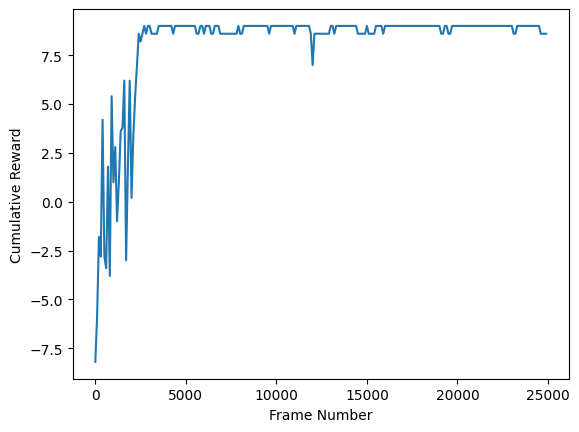

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: Deprecat

This is one. Let's use our blocks to build the number. To build one , pick up the first unit block .


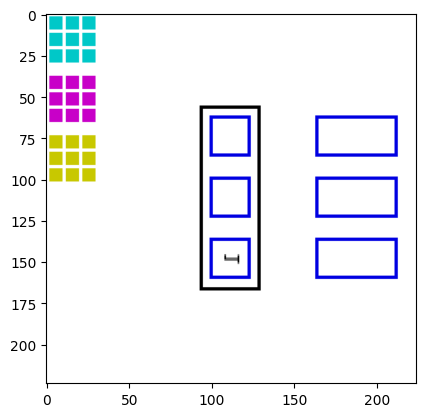

Action 2
Put the unit block in the unit's palce .


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


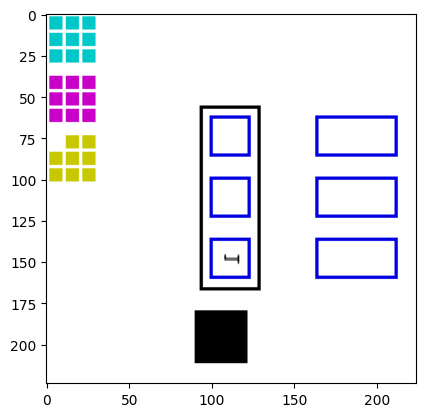

Action 5
Cumulative Reward ~ 9; TimeTaken ~ 2


In [9]:
plot_ppo(suffix[0][-1])
run_best_env(1,suffix[0][-1])

In [11]:
!python3 -W ignore ppo.py --model 1 --ease -1 --iter 500

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibilit

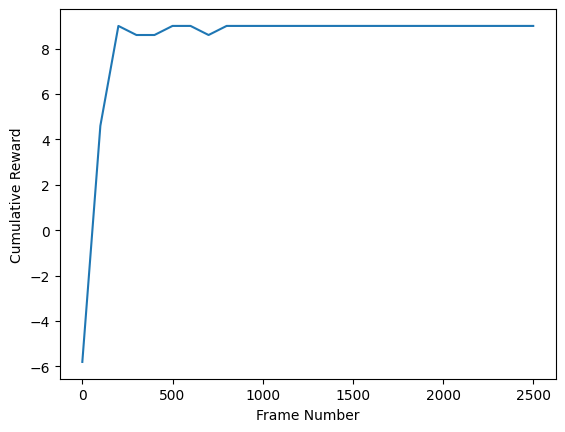

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3/dist-packages/urllib3/util/ssl_.py:256: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or PROTOCOL_TLS)
/usr/lib/python3/dist-packages/urllib3/connection.py:410: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)
Some weights of the model checkpoint at bert-base-uncased were

{'input_ids': tensor([[ 101, 2023, 2003, 2028, 1012, 2292, 1005, 1055, 2224, 2256, 5991, 2000,
         3857, 1996, 2193, 1012, 2000, 3857, 2028, 1010, 4060, 2039, 1996, 2034,
         3131, 3796, 1012,    0,    0,    0,    0,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within th

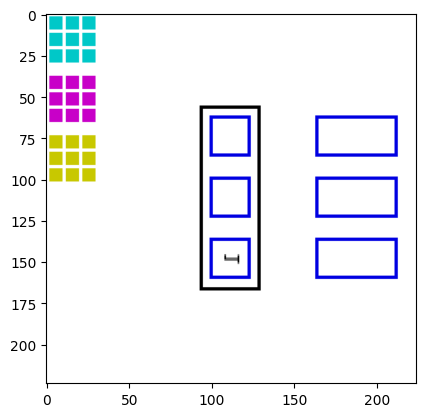

Action 2
{'input_ids': tensor([[  101,  2404,  1996,  3131,  3796,  1999,  1996,  3131,  1005,  1055,
         14412,  3401,  1012,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


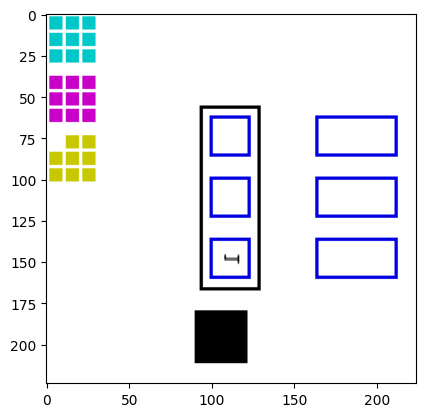

Action 5
Cumulative Reward ~ 9; TimeTaken ~ 2


In [12]:
plot_ppo(suffix[1][-1])
run_best_env(1,suffix[1][-1])

### Best Agent

In [ ]:
def best_env(number=1):
    f,s,t = number//100,(number%100)//10,number%10
    exp_action = [0,3]*f + [1,4]*s + [2,5]*t
    exp_action_indx = 0
    def human_policy(observation):
        nonlocal exp_action_indx
        # action=int(input())
        try:
            action = exp_action[exp_action_indx]
            exp_action_indx += 1
        except Exception as e:
            action = -1
        return action
    dbg=True 
    episodes=1
    env = gym.make('gym_examples/RlNlpWorld-v0',render_mode="rgb_array")
    for _ in range(episodes):
        cumulative_reward,steps=0,0
        observation = env.reset(set_no=number)
        cnt,mx_iter=0,1002
        while steps<mx_iter:
            print(observation['text'])
            if dbg==True:
                plt.imshow(observation['visual'])
                plt.show()
            action = human_policy(observation)  # User-defined policy function
            print(action)
            observation, reward, terminated, info = env.step(action)
            cumulative_reward+=reward
            steps+=1
            if dbg==True:
                print(f'cumulative_reward {cumulative_reward}; action {action}')
            if terminated:
                break
        print(f'Cumulative Reward ~ {cumulative_reward}; TimeTaken ~ {steps}')
    env.close()

In [ ]:
best_env()

## Run more difficult tasks.

In [ ]:
!python3 -W ignore ppo.py --model 0 --ease 0 --iter 2000

In [ ]:
plot_ppo(suffix[0][0]) # Plot training set.

arr = []
with open(f'results/test_set{suffix[0][0]}.json', 'r') as file:
    arr=json.load(file)

run_best_env(arr[-1],suffix[0][0]) # See the performance on the most difficult number. 

In [ ]:
!python3 -W ignore ppo.py --model 1 --ease 0 --iter 2000

In [ ]:
plot_ppo(suffix[1][0]) # Plot training set.

arr = []
with open(f'results/test_set{suffix[0][0]}.json', 'r') as file:
    arr=json.load(file)

run_best_env(arr[-1],suffix[1][0]) # See the performance on the most difficult number. 